<img src="nb_imgs/CV_ON22.png" style="border-radius:15px">

# <b><div style="color:#211894;font-size:100%;text-align:center">Welcome to the Computer Vision Track of the Hackathon! 👁</div></b>

# <b><div style="color:#211894;font-size:100%;text-align:center">[Checkout the Video Walkthrough!](https://bcove.video/3BK2hqS)</div></b>

# <a id="TOC">Table of Contents</a> 
- [1. Introduction](#1)  
    - [1.1 Learning Objectives ](#1_1)
    - [1.2 Import Libraries](#1_2)
    - [1.3 Introduction to VGG16 Model](#1_3)
    - [1.4 Hardware Component](#1_4)
    - [1.5 Software Component](#1_5)
- [2. Exploratory Data Analysis](#2)
- [4. Defining Custom VGG-16 Model](#3)  
- [5. Transfer Learning with the AI Analytics Toolkit - Intel Extention for PyTorch](#4)
- [7. Summary and Learnings](#5)

# <a class="anchor" id="2"><div style="padding:20px;color:white;margin:0;font-size:100%;text-align:left;display:fill;border-radius:10px;background-color:#251cab;overflow:hidden;background:linear-gradient(100deg, navy, #251cab, #3eb4f4, #251cab)">1 | Introduction</div></a>

In this notebook, we'll introduce the <b>[Visual Quality Inspection AI Reference Kit](https://github.com/oneapi-src/visual-quality-inspection)</b> and show you how to use Intel-optimized libraries for machine learning so you can win the Hackathon! The reference kit GitHub page provides a link to various datasets that all revolve around the concept of visually inspecting damaged products in the manufacturing process. In the future, you could play around with toothbrush, tiles, wood, etc. but in this notebook we will focus on pill quality. In this dataset, consumer over the counter medicial supplements are classfified into good or bad categories. Bad pills are ones that contain chips, cracks, or mishapen features. 

## <b><a class="anchor" id="1_1"><span style="padding:0px;color:#251cab;margin:0;font-size:100%;text-align:left;display:fill;border-radius:10px;background-color:white;overflow:hidden">1.1 | Learning Objectives</span></a></b>
Given this Visual Quality Inspection dataset, you'll build an end-to-end Machine Learning pipeline using Intel's oneAPI toolkits to optimize the training cycles, prediction throughput, and accuracy. The main component we'll be working with is <b>[Intel&reg; extension for PyTorch](https://pytorch.org/tutorials/recipes/recipes/intel_extension_for_pytorch.html)</b>.

## <b><a class="anchor" id="1_2"><span style="padding:0px;color:#251cab;margin:0;font-size:100%;text-align:left;display:fill;border-radius:10px;background-color:white;overflow:hidden">1.2 | Import Libraries</span></a></b>


In [1]:
import os
import sys
import time
import argparse
import itertools
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import intel_extension_for_pytorch
import boto3
import pandas as pd 

from torch import nn
from torch import optim
from torch.autograd import Variable
from torchvision import models
from matplotlib.patches import Rectangle
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms
from sklearn.model_selection import train_test_split, StratifiedKFold

# adding src to path 
module_path = os.path.abspath(os.path.join('./src'))
if module_path not in sys.path:
    sys.path.append(module_path)

# utilities
from src.utils.dataloader import get_train_test_loaders
from src.utils.helper import train, evaluate, predict_localize
from src.utils.dataloader import get_train_test_loaders

## <b><a class="anchor" id="1_2"><span style="padding:0px;color:#251cab;margin:0;font-size:100%;text-align:left;display:fill;border-radius:10px;background-color:white;overflow:hidden">1.3 | Introduction to VGG16 Model</span></a></b>


VGG-16 is a convolutional neural network that is 16 layers deep and same has been used as classification architecture to classify the good and defect samples from the production pipeline. Intel® Extension for PyTorch* is used for transfer learning the VGGNet classification architecture on the pill dataset created. Same experiment performed in stock PyTorch version of VGGNet.

VGG-16 was one of the best performing architectures in the ILSVRC challenge 2014. It was the runner up in the classification task with a top-5 classification error of 7.32% (only behind GoogLeNet with a classification error of 6.66%). It was also the winner of localization task with 25.32% localization error.

Limitations Of VGG 16:

- It is very slow to train from scratch.
- The size of VGG-16 trained imageNet weights is 528 MB. So, it takes quite a lot of disk space and bandwidth which makes it inefficient.
- 138 million parameters lead to exploding gradients problem.

**Some Helpful Resources**: 
- Link to VGG16 paper: https://arxiv.org/abs/1409.1556
- Link to GeekforGeeks Article: https://www.geeksforgeeks.org/vgg-16-cnn-model/

## <b><a class="anchor" id="1_2"><span style="padding:0px;color:#251cab;margin:0;font-size:100%;text-align:left;display:fill;border-radius:10px;background-color:white;overflow:hidden">1.4 | Hardware Component</span></a></b>

In this track of the Hackathon, we will be using a 3rd Generation Intel&reg; Xeon&reg; Platinum 8375C processor, which is an Ice Lake CPU, on an AWS M6i.4xlarge instance. The details of the hardware are shown below.

In [2]:
!lscpu

Architecture:            x86_64
  CPU op-mode(s):        32-bit, 64-bit
  Address sizes:         46 bits physical, 48 bits virtual
  Byte Order:            Little Endian
CPU(s):                  16
  On-line CPU(s) list:   0-15
Vendor ID:               GenuineIntel
  Model name:            Intel(R) Xeon(R) Platinum 8375C CPU @ 2.90GHz
    CPU family:          6
    Model:               106
    Thread(s) per core:  2
    Core(s) per socket:  8
    Socket(s):           1
    Stepping:            6
    BogoMIPS:            5799.92
    Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mc
                         a cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscal
                         l nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopo
                         logy nonstop_tsc cpuid aperfmperf tsc_known_freq pni pc
                         lmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe 
                         popcnt tsc_deadline_timer aes xsave 

## <b><a class="anchor" id="1_2"><span style="padding:0px;color:#251cab;margin:0;font-size:100%;text-align:left;display:fill;border-radius:10px;background-color:white;overflow:hidden">1.5 | Software Component</span></a></b>

##### This section covers the prediction time comparison between Stock PyTorch 1.8.0 and Intel PyTorch Extension (IPEX) 1.8.0 for this model.

Key Takeaways

- Realtime prediction time speedup with IPEX 1.8.0 shows up to 2.22x against stock Pytorch 1.8.0 for the Pill anomaly detection model
- Batch prediction time speedup with IPEX 1.8.0 shows from 1.04x to 1.38x against stock Pytorch 1.8.0 for the Pill anomaly detection model

<img src="nb_imgs/pytorch_prediction_time.png" style="border-radius:15px">

#### What benefits do you get from PyTorch on Intel and IPEX? 

Intel Extension for PyTorch* extends PyTorch with optimizations for extra performance boost on Intel hardware. Most of the optimizations will be included in stock PyTorch releases eventually, and the intention of the extension is to deliver up to date features and optimizations for PyTorch on Intel hardware, examples include AVX-512 Vector Neural Network Instructions (AVX512 VNNI) and Intel® Advanced Matrix Extensions (Intel® AMX).

Intel® Extension for PyTorch* has been released as an open–source project at Github.

#### Features
- Ease-of-use Python API: Intel® Extension for PyTorch* provides simple frontend Python APIs and utilities for users to get performance optimizations such as graph optimization and operator optimization with minor code changes. Typically, only 2 to 3 clauses are required to be added to the original code.
- Channels Last: Comparing to the default NCHW memory format, channels_last (NHWC) memory format could further accelerate convolutional neural networks. In Intel® Extension for PyTorch*, NHWC memory format has been enabled for most key CPU operators, though not all of them have been merged to PyTorch master branch yet. They are expected to be fully landed in PyTorch upstream soon.
- Auto Mixed Precision (AMP): Low precision data type BFloat16 has been natively supported on the 3rd Generation Xeon scalable Servers (aka Cooper Lake) with AVX512 instruction set and will be supported on the next generation of Intel® Xeon® Scalable Processors with Intel® Advanced Matrix Extensions (Intel® AMX) instruction set with further boosted performance. The support of Auto Mixed Precision (AMP) with BFloat16 for CPU and BFloat16 optimization of operators have been massively enabled in Intel® Extension for PyTorch*, and partially upstreamed to PyTorch master branch. Most of these optimizations will be landed in PyTorch master through PRs that are being submitted and reviewed.
- Graph Optimization: To optimize performance further with torchscript, Intel® Extension for PyTorch* supports fusion of frequently used operator patterns, like Conv2D+ReLU, Linear+ReLU, etc. The benefit of the fusions are delivered to users in a transparent fashion. Detailed fusion patterns supported can be found here. The graph optimization will be up-streamed to PyTorch with the introduction of oneDNN Graph API.
- Operator Optimization: Intel® Extension for PyTorch* also optimizes operators and implements several customized operators for performance. A few ATen operators are replaced by their optimized counterparts in Intel® Extension for PyTorch* via ATen registration mechanism. Moreover, some customized operators are implemented for several popular topologies. For instance, ROIAlign and NMS are defined in Mask R-CNN. To improve performance of these topologies, Intel® Extension for PyTorch* also optimized these customized operators.

# <a class="anchor" id="2"><div style="padding:20px;color:white;margin:0;font-size:100%;text-align:left;display:fill;border-radius:10px;background-color:#251cab;overflow:hidden;background:linear-gradient(100deg, navy, #251cab, #3eb4f4, #251cab)">2 | Exploratory Data Analysis</div></a>

#### Quality control in the pharmaceutical industry is a very critical component. Let’s look at the different aspects of acceptable and defective pills. 

Some of the defects that we can expect: 
- color 
- contamination 
- crack
- fault imprint
- wrong pill type
- scratches

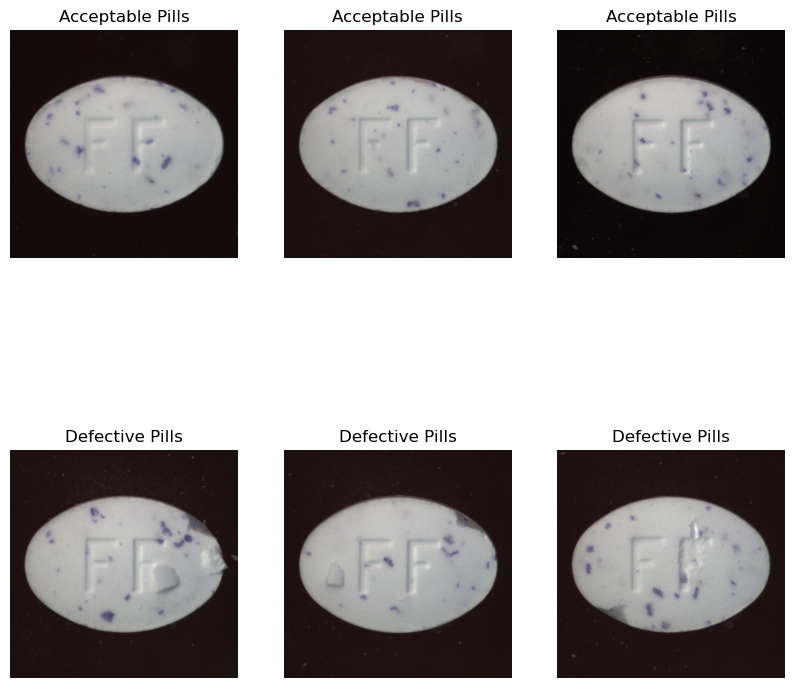

Number of Acceptable Samples 210
Number of Defective Samples 357


In [3]:
import cv2

train_dir = './data/train' # image folder

# get the list of jpegs from sub image class folders
good_imgs = [fn for fn in os.listdir(f'{train_dir}/good') if fn.endswith('.png')]
bad_imgs = [fn for fn in os.listdir(f'{train_dir}/bad') if fn.endswith('.png')]

# randomly select 3 of each
select_norm = np.random.choice(good_imgs, 3, replace = False)
select_pneu = np.random.choice(bad_imgs, 3, replace = False)

# plotting 2 x 3 image matrix
fig = plt.figure(figsize = (10,10))
for i in range(6):
    if i < 3:
        fp = f'{train_dir}/good/{select_norm[i]}'
        label = 'Acceptable Pills'
    else:
        fp = f'{train_dir}/bad/{select_pneu[i-3]}'
        label = 'Defective Pills'
    ax = fig.add_subplot(2, 3, i+1)
    
    # to plot without rescaling, remove target_size
    fn = cv2.imread(fp)
    fn_gray = cv2.cvtColor(fn, cv2.COLOR_BGR2GRAY)
    plt.imshow(fn, cmap='Greys_r')
    plt.title(label)
    plt.axis('off')
plt.show()

# also check the number of files here
print(f'Number of Acceptable Samples {len(good_imgs)}')
print(f'Number of Defective Samples {len(bad_imgs)}')

#### Convert images to numpy arrays for deeper analysis

In [4]:
# making n X m matrix
def img2np(path, list_of_filename, size = (64, 64)):
    # iterating through each file
    for fn in list_of_filename:
        fp = path + fn
        current_image = cv2.imread(fp)
        current_image = cv2.cvtColor(current_image, cv2.COLOR_BGR2GRAY)
        
        # covert image to a matrix
   #    img_ts = image.img_to_array(current_image)
        # turn that into a vector / 1D array
        img_ts = [current_image.ravel()]
        try:
            # concatenate different images
            full_mat = np.concatenate((full_mat, img_ts))
        except UnboundLocalError: 
            # if not assigned yet, assign one
            full_mat = img_ts
    return full_mat

# run it on our folders
good_images = img2np(f'{train_dir}/good/', good_imgs)
bad_images = img2np(f'{train_dir}/bad/', bad_imgs)

#### Statistical-Visual analysis of "Acceptable" and "Defective" Pills

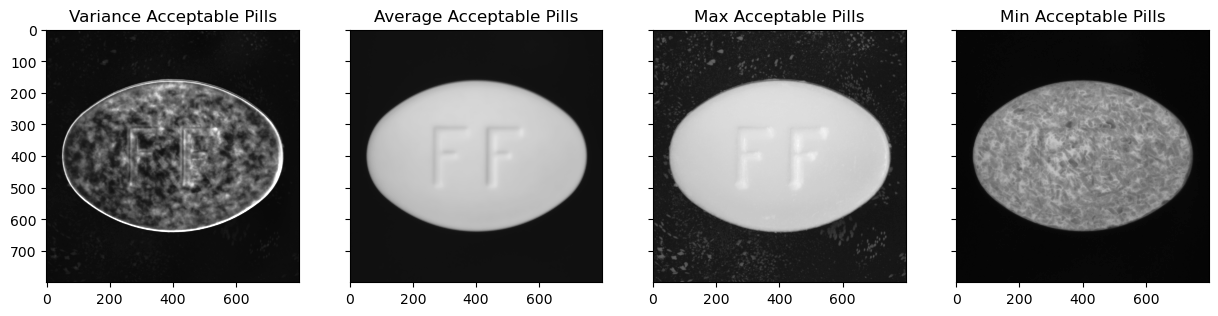

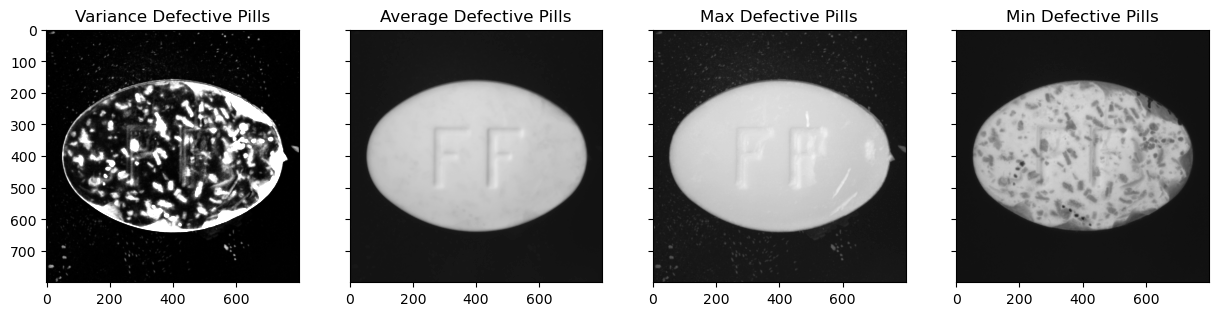

In [5]:
def find_stat_img(full_mat, title, size = (800, 800)):
    # calculate the average
    mean_img = np.mean(full_mat, axis = 0)
    mean_img = mean_img.reshape(size)
    var_img = np.var(full_mat, axis = 0)
    var_img = var_img.reshape(size)
    max_img = np.amax(full_mat, axis = 0)
    max_img = max_img.reshape(size)
    min_img = np.amin(full_mat, axis = 0)
    min_img = min_img.reshape(size)
    
    figure, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True, figsize=(15, 15))
    ax1.imshow(var_img, vmin=0, vmax=255, cmap='Greys_r')
    ax1.set_title(f'Variance {title}')
    ax2.imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r')
    ax2.set_title(f'Average {title}')
    ax3.imshow(max_img, vmin=0, vmax=255, cmap='Greys_r')
    ax3.set_title(f'Max {title}')
    ax4.imshow(min_img, vmin=0, vmax=255, cmap='Greys_r')
    ax4.set_title(f'Min {title}')
    plt.show()
    return mean_img, var_img

good_mean, good_var = find_stat_img(good_images, 'Acceptable Pills')
bad_mean, bad_var = find_stat_img(bad_images, 'Defective Pills')

#### The difference between the average "Acceptable" and "Defective" pills indicates the ares most often aflicted by defects.

We see from this analysis that the main difference between Acceptable and Defective pills is a small defect in the upper right of the pills and what appears to be discoloration on the right side of the pill. This could indicate an issue with the manufacturing process that damages the right side of some pills. 

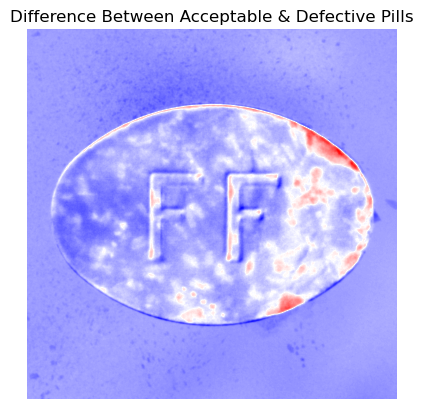

In [6]:
contrast_mean = good_mean - bad_mean
plt.imshow(contrast_mean, cmap='bwr')
plt.title(f'Difference Between Acceptable & Defective Pills')
plt.axis('off')
plt.show()

# <a class="anchor" id="2"><div style="padding:20px;color:white;margin:0;font-size:100%;text-align:left;display:fill;border-radius:10px;background-color:#251cab;overflow:hidden;background:linear-gradient(100deg, navy, #251cab, #3eb4f4, #251cab)">3 | VGG-16 Model Definition</div></a>

## <b><a class="anchor" id="1_1"><span style="padding:0px;color:#251cab;margin:0;font-size:100%;text-align:left;display:fill;border-radius:10px;background-color:white;overflow:hidden">3.1 | VGG-16 Model</span></a></b>

Custom multi-class classification model with VGG16 feature extractor, pretrained on ImageNet and custom classification head. Parameters for the first convolutional blocks are frozen to allow for transfer learning.

##### What does this function return?
- Returns class scores when in train mode.
- Returns class probs and normalized feature maps when in eval mode.

In [13]:
class CustomVGG(nn.Module):

    def __init__(self, n_classes=2):
        super().__init__()
        self.feature_extractor = models.vgg16(pretrained=True).features[:-1]
        self.classification_head = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.AvgPool2d(
                kernel_size=(INPUT_IMG_SIZE[0] // 2 ** 5, INPUT_IMG_SIZE[1] // 2 ** 5)
            ),
            nn.Flatten(),
            nn.Linear(
                in_features=self.feature_extractor[-2].out_channels,
                out_features=n_classes,
            ),
        )
        # self._freeze_params()

    def _freeze_params(self):
        for param in self.feature_extractor[:23].parameters():
            param.requires_grad = False

    def forward(self, x_in):
        """
        forward
        """
        feature_maps = self.feature_extractor(x_in)
        scores = self.classification_head(feature_maps)

        if self.training:
            return scores

        probs = nn.functional.softmax(scores, dim=-1)

        weights = self.classification_head[3].weight
        weights = (
            weights.unsqueeze(-1)
            .unsqueeze(-1)
            .unsqueeze(0)
            .repeat(
                (
                    x_in.size(0),
                    1,
                    1,
                    INPUT_IMG_SIZE[0] // 2 ** 4,
                    INPUT_IMG_SIZE[0] // 2 ** 4,
                )
            )
        )
        feature_maps = feature_maps.unsqueeze(1).repeat((1, probs.size(1), 1, 1, 1))
        location = torch.mul(weights, feature_maps).sum(axis=2)
        location = F.interpolate(location, size=INPUT_IMG_SIZE, mode="bilinear")

        maxs, _ = location.max(dim=-1, keepdim=True)
        maxs, _ = maxs.max(dim=-2, keepdim=True)
        mins, _ = location.min(dim=-1, keepdim=True)
        mins, _ = mins.min(dim=-2, keepdim=True)
        norm_location = (location - mins) / (maxs - mins)

        return probs, norm_location

## <b><a class="anchor" id="1_1"><span style="padding:0px;color:#251cab;margin:0;font-size:100%;text-align:left;display:fill;border-radius:10px;background-color:white;overflow:hidden">3.2 | Variables, Constants, and Hyperparameters</span></a></b>

In [14]:
# Setting NEG_CLASS value
NEG_CLASS = 1 # when this is equal to 1, it designates weeds as class 1
INPUT_IMG_SIZE = (224,224)

# Setting Variables
data_folder = r'data/'
subset_name = f'./models/{team_name}'

# Parameters used for the training DL model and hyperparameter Tuning
BATCH_SIZE = 10
TARGET_TRAINING_ACCURACY = .77
LR = 0.01
EPOCHS = 1
class_weight = [1, 3] if NEG_CLASS == 1 else [3, 1]
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
HEATMAP_THRESH = 0.7

# <a class="anchor" id="2"><div style="padding:20px;color:white;margin:0;font-size:100%;text-align:left;display:fill;border-radius:10px;background-color:#251cab;overflow:hidden;background:linear-gradient(100deg, navy, #251cab, #3eb4f4, #251cab)">4 | Transfer Learning with oneAPI AI Analytics Toolkit PyTorch Extension</div></a>

## <b><a class="anchor" id="1_1"><span style="padding:0px;color:#251cab;margin:0;font-size:100%;text-align:left;display:fill;border-radius:10px;background-color:white;overflow:hidden">4.1 | Intel Extension for PyTorch</span></a></b>

PyTorch is a machine learning open source framework, and is based on the popular Torch library. PyTorch is designed to provide good flexibility and high speeds for deep neural network implementation. PyTorch is different from other deep learning frameworks in that it uses dynamic computation graphs. While static computational graphs (like those used in TensorFlow) are defined prior to runtime, dynamic graphs are defined "on the fly" via the forward computation. In other words, the graph is rebuilt from scratch on every iteration.

Intel® Extension for PyTorch provides additional optimizations for an extra performance boost on Intel® CPU.

In [15]:
# importing Intel Extenstion for PyTorch
import intel_extension_for_pytorch as ipex

# Create data loaders
train_loader, test_loader = get_train_test_loaders(
    root=data_folder, batch_size=BATCH_SIZE, test_size=0.2, random_state=42,)

Dataset data/: N Images = 637, Share of anomalies = 0.568


#### Intel® Extension for PyTorch* is used for transfer learning the VGGNet classification architecture on the pill dataset created. 

Essentially we are taking a pre-trained Torch VGG16 model and transfer learning using the pill dataset.

In [16]:
# model training starts
# Model Training
# Intitalization of DL architechture along with optimizer and loss function
model = CustomVGG()
class_weight = torch.tensor(class_weight).type(torch.FloatTensor).to(DEVICE)
criterion = nn.CrossEntropyLoss(weight=class_weight)
optimizer = optim.Adam(model.parameters(), lr=LR)

# Ipex Optimization
model, optimizer = ipex.optimize(model=model, optimizer=optimizer, dtype=torch.float32)


# Training module
start_time = time.time()
trained_model = train(train_loader, model=model, optimizer=optimizer, criterion=criterion, epochs=EPOCHS,
    device=DEVICE, target_accuracy=TARGET_TRAINING_ACCURACY)
train_time = time.time()-start_time

latest_run_id = run.info.run_id

# Saving hdf5 PyTorch Model
model_path = f"{subset_name}.h5"
torch.save(trained_model, model_path)


/home/ubuntu/miniconda3/envs/cv_hackathon_ipex/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/miniconda3/envs/cv_hackathon_ipex/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/1: Loss = 24450486.9766, Accuracy = 0.4980


2022-09-26 07:08:24,853 - botocore.credentials - INFO - Found credentials in shared credentials file: ~/.aws/credentials


#### Let's evaluate the architecture of our trained model and see the total trained parameters

In [17]:
from torchsummary import summary

summary(trained_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       _IPEXConv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
       _IPEXConv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
       _IPEXConv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
       _IPEXConv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
      _IPEXConv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
      _IPEXConv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

#### Sample Evaluation and Confusion Matrix

infer_time_per_sample= 0.3943161964416504
infer_time_per_sample= 0.41095852851867676
infer_time_per_sample= 0.4048302173614502
infer_time_per_sample= 0.3972592353820801
infer_time_per_sample= 0.38329100608825684
infer_time_per_sample= 0.3697090148925781
infer_time_per_sample= 0.3639872074127197
infer_time_per_sample= 0.34653687477111816
infer_time_per_sample= 0.34450650215148926
infer_time_per_sample= 0.32078981399536133
infer_time_per_sample= 0.3378458023071289
infer_time_per_sample= 0.3236083984375
infer_time_per_sample= 0.2633187770843506
f1 Accuracy Score:  0.7263681592039801
Balanced Accuracy:  0.5


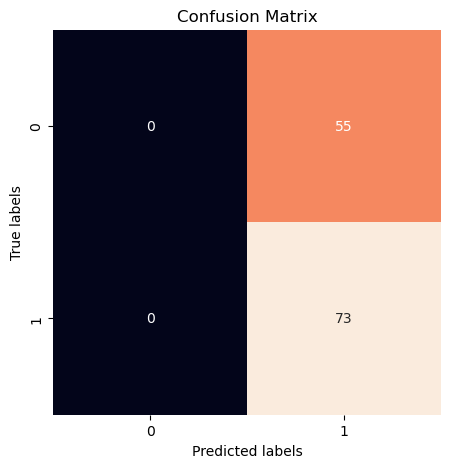

In [18]:
y_true, y_pred = evaluate(trained_model, test_loader, DEVICE, labels=True)

# <a class="anchor" id="2"><div style="padding:20px;color:white;margin:0;font-size:100%;text-align:left;display:fill;border-radius:10px;background-color:#251cab;overflow:hidden;background:linear-gradient(100deg, navy, #251cab, #3eb4f4, #251cab)">7 | Summary and Learnings</div></a>

With just a few additions to our code, we have been able to optimize a custom VGG16 binary classification model on intel hardware. Our ability to transfer learn efficiently has allowed us to take a pre-trained torch VGG16 model and transfer learn (tune) with images from our pill dataset and turn it into an efficient classification tool for pharmaceutical quality control.

We also learned how to track experiments and build a model registry for model serving, This is a powerful tool because it allows us to experiment more efficiently and ensure that we are bringing the most performant models to our production environments. 

## <span style="padding:0px;color:#251cab;margin:0;font-size:100%;text-align:left;display:fill;border-radius:10px;background-color:white;overflow:hidden">Notices & Disclaimers</span>
Intel optimizations, for Intel compilers or other products, may not optimize to the same degree for non-Intel products.  
Performance varies by use, configuration and other factors. Learn more on the Performance Index site.   
Performance results are based on testing as of dates shown in configurations and may not reflect all publicly available updates.  See backup for configuration details.  No product or component can be absolutely secure.   
Your costs and results may vary.   
Intel technologies may require enabled hardware, software or service activation.  
&copy; Intel Corporation.  Intel, the Intel logo, and other Intel marks are trademarks of Intel Corporation or its subsidiaries.  Other names and brands may be claimed as the property of others.  